# Z+j\psi fitting procedure

To determine the quantity P(Z+J/$\psi$|Z), we will carry out a two dimensional fit to the reconstructed invariant mass and transverse lifetime of the J/$\psi$ candidate.  This fit will consist of broadly of three parts:

* carrying out the fit on an admixture of prompt and non-prompt simulated data
* fitting a dimuon sample that is enriched in J/$\psi$
* fitting a four lepton sample that is tagged with a Z boson

This notebook will focus on the first of these measurements.

## The transverse lifetime 

Two simulated samples are going to be considered here: one consists of prompt decays of the $J/\psi$ and the other consists of a $J/\psi$ decaying from a $B$ meson.  In the latter case, the reconstructed vertex of the dimuons will indicate the the distance the $B$ meson traveled before decaying to the $J\psi$ which decays immediately to a pair of muons.  Based on the vertex information we can therefore reconstruct the $B$ meson lifetime, and discriminate between prompt and non-prompt decays.  For reference, the lifetime of the $J/\psi$ is $7 \times 10^{-21}$ seconds and of the $B$ meson is $1.5 \times 10^{-12}$ seconds.

We'll be using the transverse lifetime defined as,

$$
t_{xy} = \frac{m}{p_{T}} L_{xy}
$$

where

$$
L_{xy} = \frac{\vec{r}_{T} \vec{p}_{T}}{p_{T}}.
$$

The mass, $m$, and the $p_{T}$ are taken from the $J/\psi$.  The transverse displacement of the secondary vertex, $r_{T}$ is calucated between the reconstructed dimuon vertex and the most significant primary vertex in each event.  For the four lepton version of the analysis, the vertex reconstructed from the Z candidate will be used instead of the primary vertex.

In [3]:
#imports and setup
# change this to your working directory!!!
%cd '/home/naodell/work/z_plus_jpsi' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from functools import partial

from nllfit import Parameters, ScanParameters, Model, NLLFitter
import nllfit.fit_tools as ft
import scripts.plot_tools as pt 
import scripts.fit_helpers as fh

%matplotlib inline
plt.style.use('default')

/home/naodell/work/z_plus_jpsi


To properly carry out these fits, we will need to account for dependence of the resolution of the dimuon mass and vertex location on the muon characteristics (in particular, the momentum and centrality in the detector).  This will require a detailed study and the outcome would be a parameterization of the width of the relevant smearing parameter, i.e.,

$$
\sigma_{convolution} \equiv \sigma(p_{T, \mu_{1}}, |\eta_{\mu_{1}}|, p_{T, \mu_{2}}, |\eta_{\mu_{2}}|).
$$

For now, we can limit our focus to a subset of the muons which lie in the roughly the same $\eta$ region (focus on central, $|\eta| < 0.9$) and higher $p_{T}$ muons.

In [4]:
# get the data and apply some cuts (maybe use DataManager)
df_jpsi   = pd.read_pickle('data/flatuples/jpsi_james_2016/ntuple_JpsiToMuMu.pkl')
df_b_jpsi = pd.read_pickle('data/flatuples/jpsi_james_2016/ntuple_BtoJpsi.pkl')

# specify cuts here in the future
cuts      = 'lepton1_pt > 10. and 2.1 <= abs(lepton1_eta) < 2.4 \
             and lepton2_pt > 10  and 2.1 <= abs(lepton2_eta) < 2.4 \
             and 2.75 < zCand_mass < 3.5 and -1. < txy < 5'
df_jpsi   = df_jpsi.query(cuts) 
df_b_jpsi = df_b_jpsi.query(cuts)

# get the features for fitting
features       = ['txy', 'zCand_mass']
n_evt          = np.min((df_jpsi.shape[0], df_b_jpsi.shape[0]))
data_prompt    = df_jpsi[features].values[:n_evt].transpose()
data_nonprompt = df_b_jpsi[features].values[:n_evt].transpose()

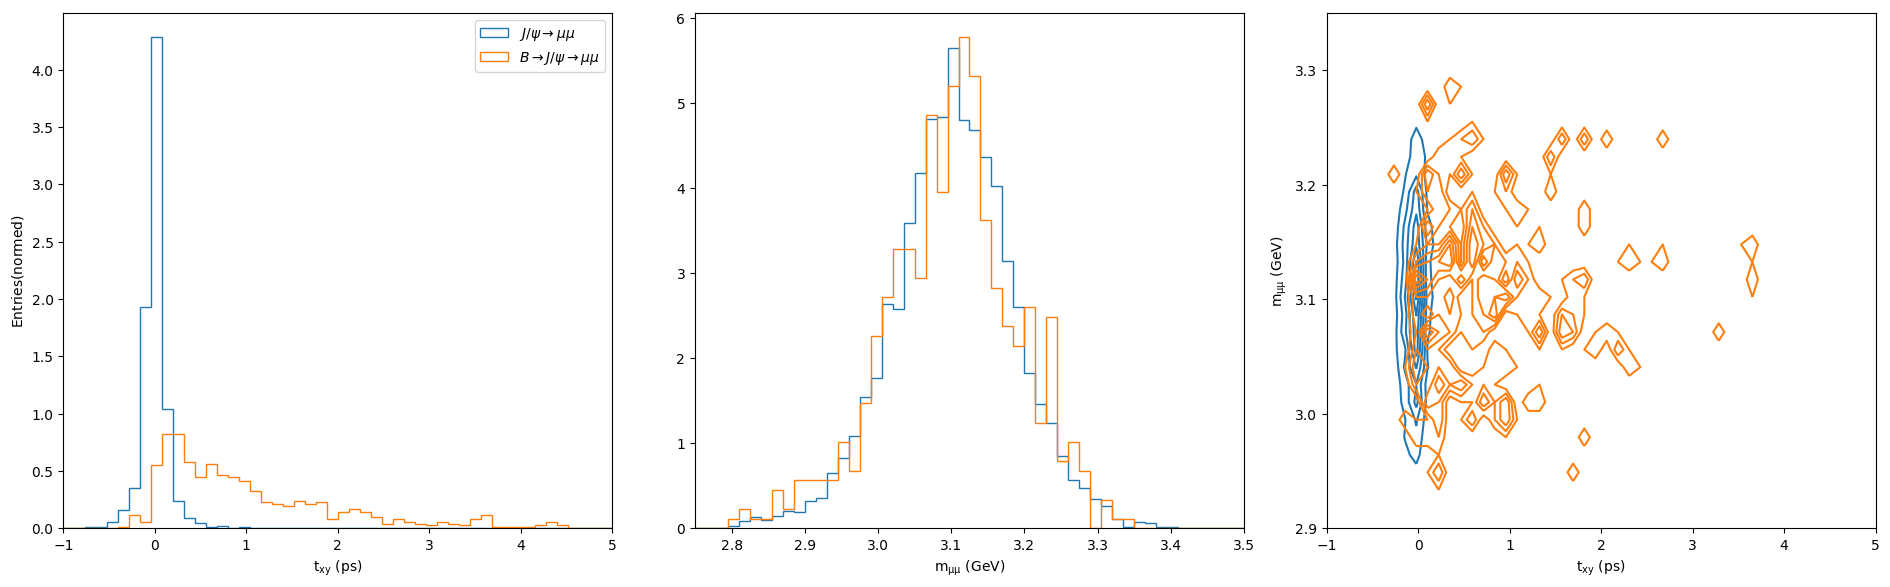

In [5]:
# Let's check out what we have here in a few plots
xlimits = (-1., 5.)
ylimits = (2.75, 3.5)

fig, axes = plt.subplots(1, 3, sharey=False, figsize=(19,6), facecolor='white')

axes[0].hist(df_jpsi.txy, color='C0', bins=50, range=xlimits, histtype='step', normed=True)
axes[0].hist(df_b_jpsi.txy, color='C1', bins=50, range=xlimits, histtype='step', normed=True)
#axes[0].set_yscale('log')
axes[0].set_xlim(xlimits)
axes[0].set_xlabel(r'$\sf t_{xy}\ (ps)$')
axes[0].set_ylabel(r'$\sf Entries (normed)$')
#axes[0].set_yscale('log')

axes[1].hist(df_jpsi.zCand_mass, color='C0', bins=50, range=ylimits, histtype='step', normed=True)
axes[1].hist(df_b_jpsi.zCand_mass, color='C1', bins=50, range=ylimits, histtype='step', normed=True)
#axes[1].set_yscale('log')
axes[1].set_xlim(ylimits)
axes[1].set_xlabel(r'$\sf m_{\mu\mu}\ (GeV)$')
#axes[1].set_yscale('log')

nbins = 50
x, y = np.linspace(xlimits[0], xlimits[1], nbins), np.linspace(ylimits[0], ylimits[1], nbins)
x, y = np.meshgrid(x, y)
hist_jpsi, _, _   = np.histogram2d(df_jpsi.txy, df_jpsi.zCand_mass, bins=nbins, range=[xlimits, ylimits])
axes[2].contour(x, y, hist_jpsi.transpose(), colors='C0')#, locator=ticker.LogLocator())

hist_b_jpsi, _, _ = np.histogram2d(df_b_jpsi.txy, df_b_jpsi.zCand_mass, bins=nbins, range=[xlimits, ylimits])
axes[2].contour(x, y, hist_b_jpsi.transpose(), colors='C1')#, locator=ticker.LogLocator())
axes[2].set_xlabel(r'$\sf t_{xy}\ (ps)$')
axes[2].set_ylabel(r'$\sf m_{\mu\mu}\ (GeV)$')
axes[2].set_ylim((2.9, 3.35))

axes[0].legend([r'$J/\psi\rightarrow \mu\mu$', r'$B\rightarrow J/\psi\rightarrow \mu\mu$'])
plt.tight_layout()
plt.show()

# Fitting the prompt data

Our models of the production pdfs will need to account for both the lifetime component and the mass component.  We will assume that these are mostly uncorrelated which seems to be the case based on the 2D distribution shown above. To come up with an appropriate pdf for the mass we need to consider the shaping factors.  These are:

* the underlying physics process (a Breit-Wigner with a narrow width),
* radiative processes that lead to energy losses,
* detector resolution effects.

Because the J/$\psi$ width is so small compared to the convoluting components, we can ignore it.  For the lossy component, we will tentatively use the a crystal ball.  This also accounts for a good portion of the detector resolution as well.  We add a second Gaussian component with the same $\mu$ as the Gaussian component of the crystal ball, but a narrower width. 

The fits will first be carried out over the 1D distributions so that we have good starting parameters for the 2D fits.

In [6]:
# prompt lifetime fit
p_lifetime_params = Parameters()                                         
p_lifetime_params.add_many(
                           #('mix11'   , 0.9  , True , 0.5 , 1. , None),
                           ('mu11'    , 0.  , True , -0.1 , 0.1 , None),
                           ('sigma11' , 0.05 , True , 0.01 , 0.2  , None),
                           )
p_lifetime_model  = Model(fh.prompt_lifetime_pdf, p_lifetime_params)
p_lifetime_fitter = NLLFitter(p_lifetime_model, min_algo='SLSQP')
p_lifetime_result = p_lifetime_fitter.fit(data_prompt[0][:1000], calculate_corr=True)

Fit finished with status: 0

[[Variables]]
    mu11:      0.01064584 +/- 0.007620 (71.58%) (init= 0)
    sigma11:   0.18493822 +/- 0.005387 (2.91%) (init= 0.05)

[[Correlation matrix]]
[[  1.000e+00  -2.479e-05]
 [ -2.479e-05   1.000e+00]] 



In [7]:
# prompt mass fit 
p_mass_params = Parameters()                                         
p_mass_params.add_many(
                       #('mix21'   , 0.5  , True, 0.01, 1., None),
                       ('mu21'    , 3.1  , True, 3.  , 3.2 , None),
                       ('sigma21' , 0.05 , True, 0.01  , 0.5  , None),
                       ('n'       , 3.5  , True, 1.01, None, None),
                       ('alpha'   , 2.   , True, 1., 3., None),
                       #('sigma22' , 0.1  , True , 0.01 , 0.5  , None),
                       )            

p_mass_model  = Model(fh.prompt_mass_pdf, p_mass_params)
p_mass_fitter = NLLFitter(p_mass_model, min_algo='SLSQP')
p_mass_result = p_mass_fitter.fit(data_prompt[1][:1000], calculate_corr=False)

Fit finished with status: 0

[[Variables]]
    mu21:      3.10775300 +/- 3.107753 (100.00%) (init= 3.1)
    sigma21:   0.07737104 +/- 0.077371 (100.00%) (init= 0.05)
    n:         49.8685510 +/- 49.86855 (100.00%) (init= 3.5)
    alpha:     1.79255833 +/- 1.792558 (100.00%) (init= 2)

[[Correlation matrix]]
0.0 



In [8]:
# nonprompt lifetime fit
np_lifetime_params = Parameters()                                         
np_lifetime_params.add_many(
                           ('tau21'    , 1.  , True , 0.1   , 3. , None),
                           ('sigma21'  , 0.5 , True , 0.01 , 1.  , None),
                           )
np_lifetime_model  = Model(fh.nonprompt_lifetime_pdf, np_lifetime_params)
np_lifetime_fitter = NLLFitter(np_lifetime_model)
np_lifetime_result = np_lifetime_fitter.fit(data_nonprompt[0][:], calculate_corr=True)

Fit finished with status: 0

[[Variables]]
    tau21:     1.02427915 +/- 0.042559 (4.16%) (init= 1)
    sigma21:   0.14000438 +/- 0.014617 (10.44%) (init= 0.5)

[[Correlation matrix]]
[[ 1.   -0.02]
 [-0.02  1.  ]] 



In [9]:
# prompt mass fit 
np_mass_params = Parameters()                                         
np_mass_params.add_many(
                       ('mix21'   , 0.5  , True, 0.01, 1., None),
                       ('mu21'    , 3.1  , True, 3.  , 3.2 , None),
                       ('sigma21' , 0.05 , True, 0.01  , 0.5  , None),
                       ('n'       , 2.5  , True, 1.01, None, None),
                       ('alpha'   , 1.   , True, 0.5, 3., None),
                       #('sigma22' , 0.1  , True , 0.01 , 0.5  , None),
                       )            

np_mass_pdf    = partial(fh.nonprompt_mass_pdf, limits=ylimits)
np_mass_model  = Model(np_mass_pdf, np_mass_params)
np_mass_fitter = NLLFitter(np_mass_model, min_algo='SLSQP')
np_mass_result = np_mass_fitter.fit(data_nonprompt[1][:1000], calculate_corr=False)

Fit finished with status: 0

[[Variables]]
    mix21:     1          +/- 1        (100.00%) (init= 0.5)
    mu21:      3.09976091 +/- 3.099760 (100.00%) (init= 3.1)
    sigma21:   0.09075054 +/- 0.090750 (100.00%) (init= 0.05)
    n:         2.50000000 +/- 2.500000 (100.00%) (init= 2.5)
    alpha:     1          +/- 1        (100.00%) (init= 1)

[[Correlation matrix]]
0.0 



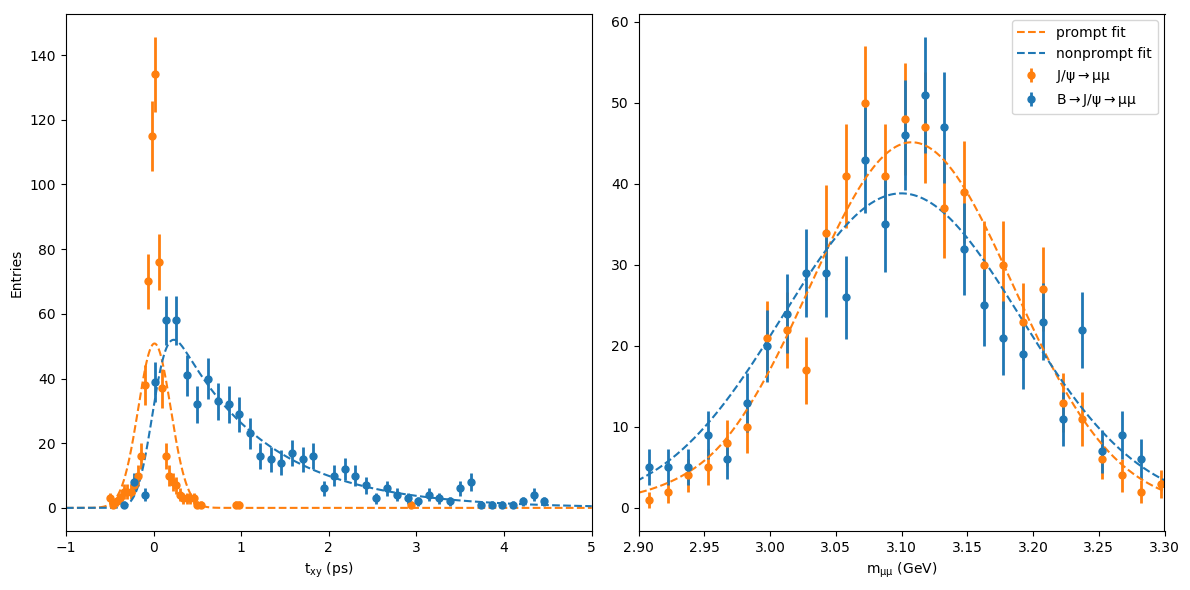

In [10]:
# Prompt 1D validation plots
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(12,6), facecolor='white')
x, y = np.linspace(xlimits[0], xlimits[1], 1000), np.linspace(ylimits[0], ylimits[1], 1000)

# prompt
nbins_x, nbins_y = 150, 50
fh.ebar_wrapper(data_prompt[0], axes[0], nbins_x, xlimits, 'C1o')
fh.ebar_wrapper(data_prompt[1], axes[1], nbins_y, ylimits, 'C1o')

fx = fh.prompt_lifetime_pdf(x, p_lifetime_result.x)
fx *= ((xlimits[1] - xlimits[0])/nbins_x)*data_prompt[0].size
axes[0].plot(x, fx, 'C1--')

fy = fh.prompt_mass_pdf(y, p_mass_result.x)
fy *= ((ylimits[1] - ylimits[0])/nbins_y)*data_prompt[1].size
axes[1].plot(y, fy, 'C1--')

# nonprompt
nbins_x, nbins_y = 50, 50
fh.ebar_wrapper(data_nonprompt[0], axes[0], nbins_x, xlimits, 'C0o')
fh.ebar_wrapper(data_nonprompt[1], axes[1], nbins_y, ylimits, 'C0o')

fx = fh.nonprompt_lifetime_pdf(x, np_lifetime_result.x)
fx *= ((xlimits[1] - xlimits[0])/nbins_x)*data_nonprompt[0].size
axes[0].plot(x, fx, 'C0--')

fy = fh.nonprompt_mass_pdf(y, np_mass_result.x)
fy *= ((ylimits[1] - ylimits[0])/nbins_y)*data_nonprompt[1].size
axes[1].plot(y, fy, 'C0--')

# styles
#axes[0].set_yscale('log')
#axes[0].set_ylim((0.5, 1e3))
axes[0].set_xlim((-1., 5))
axes[0].set_xlabel(r'$\sf t_{xy}\ (ps)$')
axes[0].set_ylabel('Entries')

#axes[1].set_yscale('log')
axes[1].set_xlim((2.9, 3.3))
axes[1].set_xlabel(r'$\sf m_{\mu\mu}\ (GeV)$')

axes[1].legend([r'prompt fit', r'nonprompt fit', 
                r'$\sf J/\psi\rightarrow \mu\mu$',  r'$\sf B \rightarrow J/\psi\rightarrow \mu\mu$'])
plt.tight_layout()
plt.show()

## test mixture model

In real data these two components (prompt and non-prompt) will appear along with a non-resonant component.  To estimate their relative contributions, we will model the data using a mixture model,

$$
f_{mix}(x;\boldsymbol{\theta}) = A f_{prompt}(x;\boldsymbol{\theta}_{prompt}) + (1 - A) f_{nonprompt}(x;\boldsymbol{\theta}_{nonprompt}).
$$

The proportion of prompt events is given by $A$ where $0 \leq A \leq 1$.  This can be simulated by preparing an admixture of prompt and nonprompt MC.  In the example below, the mixture will consist of 1000 prompt events and 750 nonprompt events.  A bias test would require that we construct confidence intervals while varying the relative proportions of the species.

In [11]:
# prepare admixture of simulated data
mix_data = np.concatenate((data_prompt[0,:500], data_nonprompt[0,:600]))

mix_params = Parameters()
mix_params.add_many(('A', 0.5, True, 0., 1., None))
mix_params += p_lifetime_params.copy()
mix_params += np_lifetime_params.copy()

mix_model  = Model(fh.mix_lifetime_pdf, mix_params)
mix_fitter = NLLFitter(mix_model, min_algo='SLSQP')
mix_result = mix_fitter.fit(mix_data, calculate_corr=True)

Fit finished with status: 0

[[Variables]]
    A:         0.46216410 +/- 0.020282 (4.39%) (init= 0.5)
    mu11:     -0.00946279 +/- 0.007167 (75.74%) (init= 0)
    sigma11:   0.12305194 +/- 0.005183 (4.21%) (init= 0.05)
    tau21:     1.04594294 +/- 0.049016 (4.69%) (init= 1)
    sigma21:   0.01013167 +/- 0.015930 (157.23%) (init= 0.5)

[[Correlation matrix]]
[[ 1.     0.375  0.225  0.314 -0.063]
 [ 0.375  1.     0.362  0.253  0.03 ]
 [ 0.225  0.362  1.     0.138  0.041]
 [ 0.314  0.253  0.138  1.    -0.051]
 [-0.063  0.03   0.041 -0.051  1.   ]] 



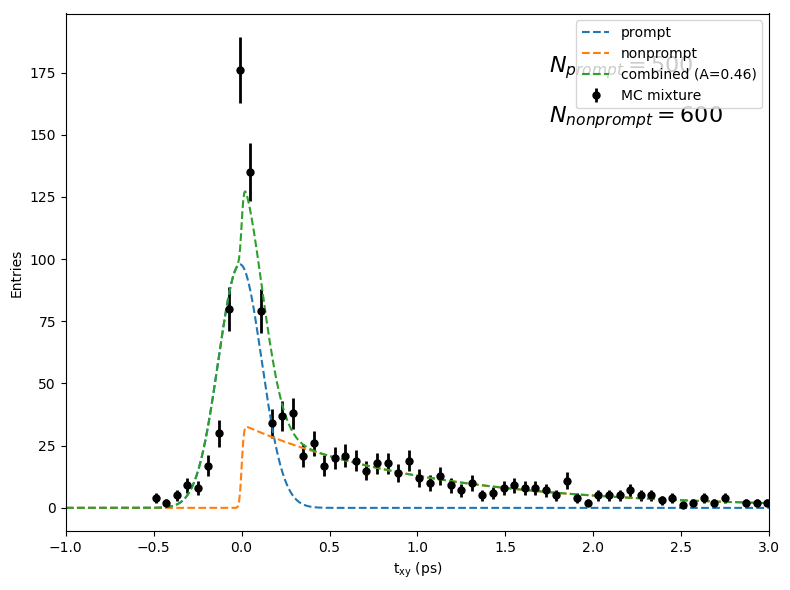

In [12]:
# Prompt 1D validation plots
fig, ax = plt.subplots(1, 1, sharey=False, figsize=(8,6), facecolor='white')
x = np.linspace(xlimits[0], xlimits[1], 1000)

nbins_x = 100
normalization = ((xlimits[1] - xlimits[0])/nbins_x)*mix_data.size
mix_const = mix_result.x[0]

f_prompt    = mix_const*normalization*fh.prompt_lifetime_pdf(x, mix_result.x[1:3]) 
f_nonprompt = (1 - mix_const)*normalization*fh.nonprompt_lifetime_pdf(x, mix_result.x[3:]) 
f_mix       = normalization*fh.mix_lifetime_pdf(x, mix_result.x) 

fh.ebar_wrapper(mix_data, ax, nbins_x, xlimits, 'ko')
ax.plot(x, f_prompt, 'C0--')
ax.plot(x, f_nonprompt, 'C1--')
ax.plot(x, f_mix, 'C2--')

# styles
#ax.set_yscale('log')
#ax.set_ylim((0.5, 2e2))
ax.set_xlim((-1., 3))
ax.set_xlabel(r'$\sf t_{xy}\ (ps)$')
ax.set_ylabel('Entries')
ax.legend([r'prompt', r'nonprompt', 
           r'combined (A={0:.2f})'.format(mix_result.x[0]),  r'MC mixture'])
ax.text(1.75, 175., r'$N_{{prompt}} = {0}$'.format(500), fontsize=16)
ax.text(1.75, 155., r'$N_{{nonprompt}} = {0}$'.format(600), fontsize=16)
plt.tight_layout()
plt.show()